In [1]:

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import skimage

100%|██████████| 1/1 [00:11<00:00, 11.76s/it]


1
(580, 224, 224, 1)
Done


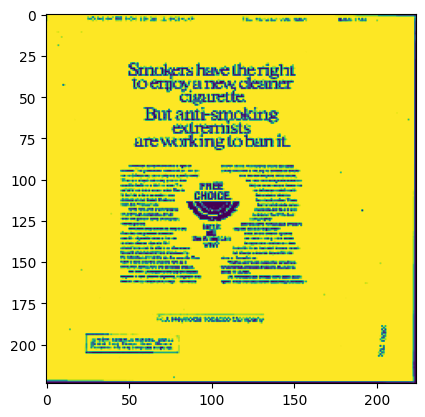

In [2]:
# data loading
data = []
path = "../data/datasets/train_set/"
classes = os.listdir(path)


def decode_img(img):
    # reading image from filepath
    I = skimage.io.imread(img)

    # check if it is in vertical orientatioon
    if I.shape[0] < I.shape[1]:
        I = I.T
    # add channel dim
    I = np.expand_dims(I, axis=-1)
    # resize and return
    return tf.image.resize(I, [224, 224])


for class_name in tqdm(classes):
    files = os.listdir(path + class_name)
    class_images = np.zeros((len(files), 224, 224,1))
    for i, file in enumerate(files):
        I = decode_img(path + class_name + "/" + file)
        class_images[i] = I
    data.append(class_images)

print(len(data))
for x in data:
    print(x.shape)

print("Done")

IndexError: list index out of range

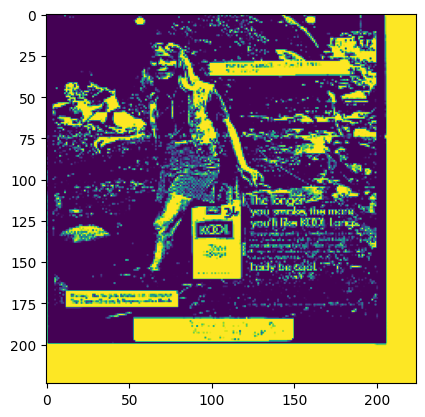

In [3]:
for i in range(4):
    plt.imshow(data[i][3])



In [ ]:
# model

In [ ]:
# generate 